This is a project built on the MLEnd dataset of audio files
Two classifications tasks are undertaken

In [ ]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os, sys, re, pickle, glob
import urllib.request
import zipfile

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

#from IPython.display import Audio
import IPython.display as ipd
from tqdm import tqdm
import librosa

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.models import Sequential

drive.mount('/content/drive')
path = '/content/drive/MyDrive/Data/MLEnd'
os.listdir(path)

#Data Download
If data doesn't exist

First, we will define a function that will allow us to download a file into a chosen location.

In [ ]:
def download_url(url, save_path):
    with urllib.request.urlopen(url) as dl_file:
        with open(save_path, 'wb') as out_file:
            out_file.write(dl_file.read())

The next step is to download the file 'training.zip' into the folder 'MyDrive/Data/MLEnd'. Note that this might take a while.

In [ ]:
url  = "https://collect.qmul.ac.uk/down?t=6H8231DQL1NGDI9A/613DLM2R3OFV5EEH9INK2OG"
save_path = '/content/drive/MyDrive/Data/MLEnd/training.zip'
download_url(url, save_path)

Finally, let's unzip the training file

In [ ]:
directory_to_extract_to = '/content/drive/MyDrive/Data/MLEnd/training/'
with zipfile.ZipFile(save_path, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

Understanding the dataset

In [ ]:
files = glob.glob('/content/drive/MyDrive/Data/MLEnd/training/*/*.wav')
print (type(files))

<class 'list'>


In [ ]:
labels = pd.read_csv('/content/drive/MyDrive/Data/MLEnd/trainingMLEnd.csv')
labels

In [ ]:
# five random files
for _ in range(5):
  n = np.random.randint(20000)
  display(ipd.Audio(files[n]))

Plotting a random audio file

In [ ]:
n=0
fs = None # Sampling frequency. If None, fs would be 22050
x, fs = librosa.load(files[n],sr=fs)
t = np.arange(len(x))/fs
plt.plot(t,x)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.show()
display(ipd.Audio(files[n]))


# 1 Basic solution

Steps:
1. Data Loading
2. Feature Extraction
3. Data Cleaning 
4. Data Preprocessing
5. Data Visualization
6. Different Model training

After all the models have been trained and validated, their respective confusion matrix and Classification Reports are generated.

#Feature Extraction

We define a function getPitch that returns the pitch of the Pitch of the audio file

In [ ]:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs, frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

The getXy function extracts the below mentioned features and returns them as anumpy array and label names in y.

The features:


1.   Power
2.   Pitch mean
3. Pitch std 
4. Voiced flag
5. Onset
6. MFCC
7. Zero Crossing Rate
8. Spectral Centroid
9. Spectral Rolloff
10. Root Mean Square

y has the intonation labels:

1. neutral
2. bored
3. excited
4. question

In [ ]:
def getXy(files,labels_file,scale_audio=False, onlySingleDigit=False):
  X,y =[],[]
  for file in tqdm(files):
    fileID = file.split('/')[-1]
    yi = list(labels_file[labels_file['File ID']==fileID]['intonation'])[0]
    if onlySingleDigit and yi>9:
      continue
    else:
      fs = None # if None, fs would be 22050
      x, fs = librosa.load(file,sr=fs)
      if scale_audio: x = x/np.max(np.abs(x))
      f0, voiced_flag = getPitch(x,fs,winLen=0.02)
      
      power = np.sum(x**2)/len(x)
      pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
      pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
      voiced_fr = np.mean(voiced_flag)

      #Extra Features 

      onset = np.mean(librosa.onset.onset_detect(x,fs))
      mfccs = np.mean(librosa.feature.mfcc(x, sr=fs))
      zcr = np.mean(librosa.feature.zero_crossing_rate(x))
      spc = np.mean(librosa.feature.spectral_centroid(x, fs))
      spr = np.mean(librosa.feature.spectral_rolloff(x, fs))
      rms = np.mean(librosa.feature.rms(x, fs))
      
      #mf1 = np.mean(mfccs)

      xi = [power,pitch_mean,pitch_std,voiced_fr,onset,mfccs,zcr,spc,spr,rms]
      X.append(xi)
      y.append(yi)
  return np.array(X),np.array(y)

We next extract the first 2000 audio samples

In [ ]:
X,y = getXy(files[:2000],labels_file=labels,scale_audio=True, onlySingleDigit=False)

100%|██████████| 2000/2000 [12:08<00:00,  2.75it/s]


In [ ]:
print('The shape of X is', X.shape) 
print('The shape of y is', y.shape)
print('The labels vector is', y)

The shape of X is (2000, 10)
The shape of y is (2000,)
The labels vector is ['bored' 'question' 'excited' ... 'excited' 'excited' 'question']


#Data Preprocessing

In [ ]:
# If nan sample, remove them
if np.sum(np.isnan(X)):
  idx = np.isnan(X).sum(1)>0
  X = X[~idx]
  y = y[~idx]
print(np.sum(np.isnan(X)))

0


Converting The numpy array to a combined DataFrame to help preprocessing and visualization

In [ ]:
#Concatinatinag X,y

data_all = np.column_stack((X,y))

#numpy array to df

df = pd.DataFrame(data_all,columns=['power','pitch_mean','pitch_std','voiced_fr','onset','mfccs','zcr','spc','spr','rms','y'])

Data Normalisation

We seperate the label and the features and then normalise the feature set

In [ ]:
X = df.copy()
del X['y']
y = df['y'].copy()

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df_normalized = scaler.fit_transform(X)

df_normalized = pd.DataFrame(df_normalized,columns=['power','pitch_mean','pitch_std','voiced_fr','onset','mfccs','zcr','spc','spr','rms'])
df_normalized.head()

,power,pitch_mean,pitch_std,voiced_fr,onset,mfccs,zcr,spc,spr,rms
0,-0.317269,0.666032,0.105282,0.256167,-0.302811,0.009339,-0.737851,-1.419257,-1.660781,-0.001522
1,1.313009,0.133875,1.199142,-0.312349,-0.647233,0.541659,-1.088153,-0.630315,-0.267860,0.447279
2,1.607051,-0.651091,-0.311855,-0.176752,-0.302811,1.344894,-0.717061,-0.752238,-0.848846,1.105017
3,-1.176973,-0.631493,-0.881617,-0.609304,-0.647233,-1.791870,1.688472,1.737182,1.877468,-1.540337
4,-0.346937,-0.076749,-0.096480,-1.377731,0.341388,0.634964,1.052882,1.206714,0.979532,-0.693631


When the data was used without standard the accuracy of the models was of the range 0.025-0.35 after the data was preprocessed the accuracy of the models increased to the range of 0.45-0.54

#Data Visualization



First we visualize the class distribution of the labels

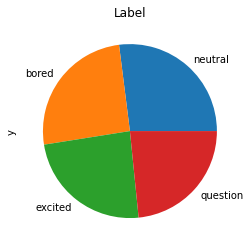

In [ ]:
df['y'].value_counts().plot(kind='pie')
plt.title('Label')
plt.grid()
plt.show()

As seen the class distribution is nearly uniform this means that the data is of good quality.


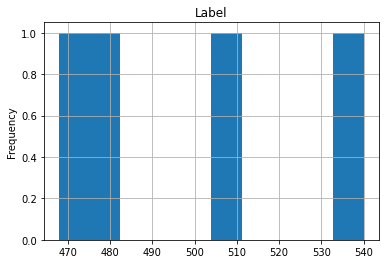

In [ ]:
df['y'].value_counts().plot(kind='hist')
plt.title('Label')
plt.grid()
plt.show()

Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df_normalized,y,test_size=0.3)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1400, 10), (600, 10), (1400,), (600,))

#Models

Next I use the preprocessed data to traing the following models of machine learning:

1. Support Vector Machine
2. Random Forest
3. KNN
4. Naive Bayes Classifier
5. Logistic Regression
6. MultiLayer Perceptron

Grid Search is used to find the best parameters of each of the models.

The models take the 10 features as input and try to classify them into the the 4 intonations.

The accuracy of the best model and its respective model parameters have been shown as well as the Confusion Matrix and the Classification Report.

SVM

In [ ]:
from sklearn import svm

parameters = {
    
    'C': [ 2,2.5, 3],
    'gamma': [ 0.2, 0.3,0.1, 0.01,0.001,0.02, 'scale'],
    'kernel': ['rbf', 'linear', 'sigmoid'],
    'class_weight': ['balanced']

}
grid_model = svm.SVC()
grid_svc = GridSearchCV(grid_model, parameters, n_jobs=-1)

grid_svc.fit(X_train,y_train)

yt_p = grid_svc.predict(X_train)
yv_p = grid_svc.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.6492857142857142
Validation  Accuracy 0.54


In [ ]:
#Scores and best model

print (grid_svc.best_score_)
print (grid_svc.best_params_)

0.5235714285714286
{'C': 2.5, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}


In [ ]:
#Best Model

model  = svm.SVC(C=2.5, gamma=0.001, kernel='rbf', class_weight='balanced')
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.495
Validation  Accuracy 0.475


Text(91.68, 0.5, 'predicted label')

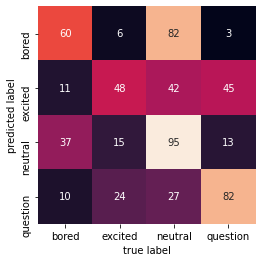

In [ ]:
#Confusion Matrix

x = metrics.confusion_matrix(y_val, yv_p, labels=['bored', 'excited', 'neutral', 'question'])
y = metrics.confusion_matrix(y_train, yt_p, labels=['bored', 'excited', 'neutral', 'question'])
tones = ['bored', 'excited', 'neutral', 'question']

sns.heatmap(x,square=True, annot=True, fmt='d', cbar=False,
            xticklabels = tones,
            yticklabels = tones)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [ ]:
print(classification_report(y_val, yv_p))

              precision    recall  f1-score   support

       bored       0.51      0.40      0.45       151
     excited       0.52      0.33      0.40       146
     neutral       0.39      0.59      0.47       160
    question       0.57      0.57      0.57       143

    accuracy                           0.48       600
   macro avg       0.50      0.47      0.47       600
weighted avg       0.49      0.47      0.47       600



Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

parameters = {
    'max_depth': [7,8,9,10],
    'criterion': ['gini', 'entropy'],
    'n_estimators':[200,300,400],
    'bootstrap': ['False'],
    'class_weight': ['balanced', 'balanced_subsample']
}

grid_rf = RandomForestClassifier()
grid_forest = GridSearchCV(grid_rf, parameters, n_jobs=-1)

grid_forest.fit(X_train,y_train)

yt_p = grid_forest.predict(X_train)
yv_p = grid_forest.predict(X_val)


In [ ]:
#Scores and Best Model Parameters

print (grid_forest.best_score_)
print (grid_forest.best_params_)

0.5592857142857144
{'bootstrap': 'False', 'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 400}


In [ ]:
#Running the best classifier
clf_1 = RandomForestClassifier(max_depth=8,  criterion='entropy', n_estimators=200, bootstrap=False, class_weight='balanced',n_jobs=-1)
clf_1.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [ ]:
yt_p = clf_1.predict(X_train)
yv_p = clf_1.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.9042857142857142
Validation  Accuracy 0.545


Text(91.68, 0.5, 'predicted label')

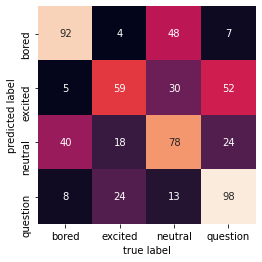

In [ ]:
#Confusion Matrix
x = metrics.confusion_matrix(y_val, yv_p, labels=['bored', 'excited', 'neutral', 'question'])
y = metrics.confusion_matrix(y_train, yt_p, labels=['bored', 'excited', 'neutral', 'question'])
tones = ['bored', 'excited', 'neutral', 'question']
sns.heatmap(x,square=True, annot=True, fmt='d', cbar=False,
            xticklabels = tones,
            yticklabels = tones)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [ ]:
print(classification_report(y_val, yv_p))

              precision    recall  f1-score   support

       bored       0.63      0.61      0.62       151
     excited       0.56      0.40      0.47       146
     neutral       0.46      0.49      0.47       160
    question       0.54      0.69      0.60       143

    accuracy                           0.55       600
   macro avg       0.55      0.55      0.54       600
weighted avg       0.55      0.55      0.54       600



KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
model_kn  = KNeighborsClassifier()

parameters= {
    'n_neighbors': [50,60,70,80,90],
    
    'leaf_size': [1,5,10,15,25]
}

grid_kn = GridSearchCV(model_kn,parameters, n_jobs=-1)
grid_kn.fit(X_train,y_train)

yt_p = grid_kn.predict(X_train)
yv_p = grid_kn.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.515
Validation  Accuracy 0.485


In [ ]:
#Best Score and Model
print(grid_kn.best_params_)
print(grid_kn.best_score_)

{'leaf_size': 1, 'n_neighbors': 60}
0.4735714285714286


In [ ]:
#Best Model

model  = KNeighborsClassifier(n_neighbors=60, p=1)
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.5192857142857142
Validation  Accuracy 0.4816666666666667


Text(91.68, 0.5, 'predicted label')

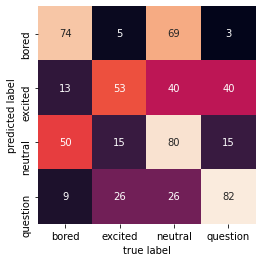

In [ ]:
#Confusion Matrix
x = metrics.confusion_matrix(y_val, yv_p, labels=['bored', 'excited', 'neutral', 'question'])
y = metrics.confusion_matrix(y_train, yt_p, labels=['bored', 'excited', 'neutral', 'question'])
tones = ['bored', 'excited', 'neutral', 'question']

sns.heatmap(x,square=True, annot=True, fmt='d', cbar=False,
            xticklabels = tones,
            yticklabels = tones)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [ ]:
#Validation Report
print(classification_report(y_val, yv_p))

              precision    recall  f1-score   support

       bored       0.51      0.49      0.50       151
     excited       0.54      0.36      0.43       146
     neutral       0.37      0.50      0.43       160
    question       0.59      0.57      0.58       143

    accuracy                           0.48       600
   macro avg       0.50      0.48      0.48       600
weighted avg       0.50      0.48      0.48       600



Naive Bayes Classifier

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train,y_train)

yt_p = gnb.predict(X_train)
yv_p = gnb.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.4707142857142857
Validation  Accuracy 0.46166666666666667


Text(91.68, 0.5, 'predicted label')

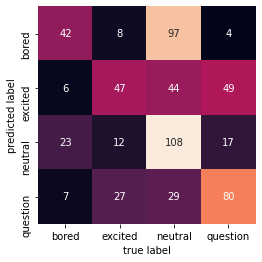

In [ ]:
#Confusion Matrix
x = metrics.confusion_matrix(y_val, yv_p, labels=['bored', 'excited', 'neutral', 'question'])
y = metrics.confusion_matrix(y_train, yt_p, labels=['bored', 'excited', 'neutral', 'question'])
tones = ['bored', 'excited', 'neutral', 'question']

sns.heatmap(x,square=True, annot=True, fmt='d', cbar=False,
            xticklabels = tones,
            yticklabels = tones)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [ ]:
print(classification_report(y_val, yv_p))

              precision    recall  f1-score   support

       bored       0.54      0.28      0.37       151
     excited       0.50      0.32      0.39       146
     neutral       0.39      0.68      0.49       160
    question       0.53      0.56      0.55       143

    accuracy                           0.46       600
   macro avg       0.49      0.46      0.45       600
weighted avg       0.49      0.46      0.45       600



Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

parameters= {
    'penalty': ['l1', 'elasticnet', 'none'],
    'C': [0.1,2,3,4,5],
    'class_weight': ['dict', 'balanced'],
    'solver': ['newton_cg', 'liblinear', 'sag', 'saga'],
    'multi_class': ['multinomial'],

}

lgr = LogisticRegression()

grid_lgr = GridSearchCV(lgr, parameters, n_jobs=-1)
grid_lgr.fit(X_train,y_train)
yt_p = grid_lgr.predict(X_train)
yv_p = grid_lgr.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.5364285714285715
Validation  Accuracy 0.5366666666666666


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [ ]:
#Best Score and Model

print(grid_lgr.best_params_)
print(grid_lgr.best_score_)

{'C': 0.1, 'class_weight': 'balanced', 'multi_class': 'multinomial', 'penalty': 'none', 'solver': 'sag'}
0.5264285714285715


In [ ]:
#Best Model
lgr = LogisticRegression(C=0.1, class_weight='balanced', multi_class='multinomial',  solver='sag')
lgr.fit(X_train,y_train)
yt_p = lgr.predict(X_train)
yv_p = lgr.predict(X_val) 

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.5321428571428571
Validation  Accuracy 0.53


Text(91.68, 0.5, 'predicted label')

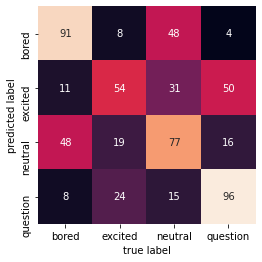

In [ ]:
#Confusion Matrix 
x = metrics.confusion_matrix(y_val, yv_p, labels=['bored', 'excited', 'neutral', 'question'])
y = metrics.confusion_matrix(y_train, yt_p, labels=['bored', 'excited', 'neutral', 'question'])
tones = ['bored', 'excited', 'neutral', 'question']
sns.heatmap(x,square=True, annot=True, fmt='d', cbar=False,
            xticklabels = tones,
            yticklabels = tones)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [ ]:
#Classification Report
print(classification_report(y_val, yv_p))

              precision    recall  f1-score   support

       bored       0.58      0.60      0.59       151
     excited       0.51      0.37      0.43       146
     neutral       0.45      0.48      0.47       160
    question       0.58      0.67      0.62       143

    accuracy                           0.53       600
   macro avg       0.53      0.53      0.53       600
weighted avg       0.53      0.53      0.53       600



MultiLayer Perceptron

In [ ]:
from sklearn.neural_network import MLPClassifier

parameters = {
    'activation': ['logistic', 'tanh'],
    'solver': ['lbfgs', 'sgd'],
    'max_iter': [300,400,500],
    'random_state': [1,2,3]
    
}

clf_grid = MLPClassifier()
grid_mlp = GridSearchCV(clf_grid, parameters, n_jobs=-1)
grid_mlp.fit(X_train,y_train)

yt_p = clf.predict(X_train)
yv_p = clf.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 1.0
Validation  Accuracy 0.4766666666666667


In [ ]:
#Best Score and Model

print(grid_mlp.best_params_)
print(grid_mlp.best_score_)

{'activation': 'tanh', 'max_iter': 300, 'random_state': 1, 'solver': 'sgd'}
0.522142857142857


In [ ]:
clf = MLPClassifier(max_iter=300, solver='sgd', activation='tanh',random_state=1).fit(X_train, y_train)
yt_p = clf.predict(X_train)
yv_p = clf.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.5328571428571428
Validation  Accuracy 0.5333333333333333


Text(91.68, 0.5, 'predicted label')

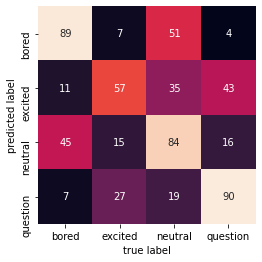

In [ ]:
#Confusion Matrix 
x = metrics.confusion_matrix(y_val, yv_p, labels=['bored', 'excited', 'neutral', 'question'])
y = metrics.confusion_matrix(y_train, yt_p, labels=['bored', 'excited', 'neutral', 'question'])
tones = ['bored', 'excited', 'neutral', 'question']
sns.heatmap(x,square=True, annot=True, fmt='d', cbar=False,
            xticklabels = tones,
            yticklabels = tones)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [ ]:
#Classification Report
print(classification_report(y_val, yv_p))

              precision    recall  f1-score   support

       bored       0.59      0.59      0.59       151
     excited       0.54      0.39      0.45       146
     neutral       0.44      0.53      0.48       160
    question       0.59      0.63      0.61       143

    accuracy                           0.53       600
   macro avg       0.54      0.53      0.53       600
weighted avg       0.54      0.53      0.53       600



After modelling and running 6 different models, all had similar accuracies. The Random Forest Classifier had the best accuracy of 0.545.

# 2 Advanced solution

Problem Statement: Formulate a machine learning problem that can be attempted using the MLEnd dataset and build a solution model 

Summary of Approach:

1. First I tried to make a model that would classify the audio into all the numerical classes (ones,tens,large numbers), but this was a complex task and the best model only achieved an accuracy of 0.04-0.05 which would have made the application meaning less.

2. Next, in order to make a meaninful application I decided to develop a model that only identifies single digits as the accuracy achieved was much higher.

The Approach For Single Digit identification

1. The all 20000 audio files are iterated through and the 10 features are extracted as well as the 10 label classes.
2. The numpy array values are saved on the drive
3. NaN values are removed
4. The numpy arrays are converted to a dataframe for easy of encoding and preprocessing
5. The dataframe is transformed using a Standard Scaler
6. PCA is performed to extract 2 and 4 sets of vectors.
7. Data Visualized to analyse class distribution, correlation and relations between features.
8. Data is split between training and testing set
9. A Deep MLP using keras is trained 


We redifine getXy to get all the previous 10 features in X and 0-9 digits in y

In [ ]:
def getXy(files,labels_file,scale_audio=False, onlySingleDigit=False):
  X,y =[],[]
  for file in tqdm(files):
    fileID = file.split('/')[-1]
    yi = list(labels_file[labels_file['File ID']==fileID]['digit_label'])[0]
    if onlySingleDigit and yi>9:
      continue
    else:
      fs = None # if None, fs would be 22050
      x, fs = librosa.load(file,sr=fs)
      if scale_audio: x = x/np.max(np.abs(x))
      f0, voiced_flag = getPitch(x,fs,winLen=0.02)
      
      power = np.sum(x**2)/len(x)
      pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
      pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
      voiced_fr = np.mean(voiced_flag)

      #Extra Features 

      onset = np.mean(librosa.onset.onset_detect(x,fs))
      mfccs = np.mean(librosa.feature.mfcc(x, sr=fs))
      zcr = np.mean(librosa.feature.zero_crossing_rate(x))
      spc = np.mean(librosa.feature.spectral_centroid(x, fs))
      spr = np.mean(librosa.feature.spectral_rolloff(x, fs))
      rms = np.mean(librosa.feature.rms(x, fs))
      
      #mf1 = np.mean(mfccs)

      xi = [power,pitch_mean,pitch_std,voiced_fr,onset,mfccs,zcr,spc,spr,rms]
      X.append(xi)
      y.append(yi)
  return np.array(X),np.array(y)

We go through all the audio files to get only the single digit files

In [ ]:

X,y = getXy(files,labels_file=labels,scale_audio=True, onlySingleDigit=True)

100%|██████████| 20000/20000 [59:24<00:00,  5.61it/s]


I found it necessary to save the numpy array as it was time consuming (60-90 mins) the extract features from 20000 files if the kernel failed

In [ ]:
# save numpy array as npy file
from numpy import asarray
from numpy import save

# save to npy file
save('/content/drive/MyDrive/Data/MLEnd/X.npy', X)
save('/content/drive/MyDrive/Data/MLEnd/y.npy', y)

In [ ]:
# load numpy array from npy file
from numpy import load
# load array
X = load('/content/drive/MyDrive/Data/MLEnd/X1.npy')
y = load('/content/drive/MyDrive/Data/MLEnd/yf.npy')

print(X[0])

[ 3.86184087e-02  1.87723934e+02  6.25988127e+01  2.91139241e-01
  1.70000000e+01 -1.06345291e+01  4.92065430e-02  1.90373308e+03
  4.33221130e+03  1.00528315e-01]


#Pre Processing Data

Removal of NaN values

In [ ]:
# If nan sample, remove them
if np.sum(np.isnan(X)):
  idx = np.isnan(X).sum(1)>0
  X = X[~idx]
  y = y[~idx]
print(np.sum(np.isnan(X)))

0


Converting to dataframe

In [ ]:
#Converting to dataframe to preprocess
dfy = pd.DataFrame(y,columns =['y'])

dfx = pd.DataFrame(X,columns=['power','pitch_mean','pitch_std','voiced_fr','onset','mfccs','zcr','spc','spr','rms'])

In [ ]:
data_all = np.column_stack((X,y))
df_all = pd.DataFrame(data_all,columns=['power','pitch_mean','pitch_std','voiced_fr','onset','mfccs','zcr','spc','spr','rms','y'])

In [ ]:
dfy['y'].unique()

array([1, 9, 6, 3, 5, 2, 0, 4, 7, 8])

Label Encoding, used if the label range in >10

as when the label set had millions it treated them as int values in the MLP, but since the task was revised this step is redundant

In [ ]:
dfy = dfy.astype('object')

In [ ]:
dfy['y'] = dfy['y'].astype('category')

In [ ]:
dfy['y'] = dfy['y'].cat.codes

In [ ]:
dfx.head()

,power,pitch_mean,pitch_std,voiced_fr,onset,mfccs,zcr,spc,spr,rms
0,0.038618,187.723934,62.598813,0.291139,17.00,-10.634529,0.049207,1903.733078,4332.211304,0.100528
1,0.006295,130.283099,5.193614,0.241176,17.00,-24.430428,0.256152,3690.346385,7203.109777,0.036047
2,0.017070,171.916609,26.854425,0.111888,32.50,-10.082903,0.208781,3290.033066,6001.483154,0.063516
3,0.021679,165.671895,28.076065,0.588785,34.50,-20.361975,0.082303,1983.699409,4216.520182,0.087940
4,0.035376,105.684323,8.642074,0.275862,37.25,-21.260151,0.077524,1743.764915,3656.931910,0.112231


In [ ]:
y = dfy['y'].to_numpy()

#################  This is residue from the label encoding to build a model for classfier to all the numerical classes (ones,tens,large numbers)

Standard Scaling of all the features

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

dfx_SS = scaler.fit_transform(dfx)

In [ ]:
dfx_SS = pd.DataFrame(dfx_SS,columns=['power','pitch_mean','pitch_std','voiced_fr','onset','mfccs','zcr','spc','spr','rms'])
dfx_SS.head()

,power,pitch_mean,pitch_std,voiced_fr,onset,mfccs,zcr,spc,spr,rms
0,1.085250,0.140534,1.264882,-0.111465,-0.765592,0.531804,-1.092119,-0.636571,-0.277747,0.481150
1,-1.097510,-0.594932,-0.841772,-0.420614,-0.765592,-1.698312,1.523715,1.598907,1.829404,-1.426601
2,-0.369886,-0.061861,-0.046864,-1.220598,0.590157,0.620975,0.924931,1.098020,0.947447,-0.613917
3,-0.058651,-0.141817,-0.002032,1.730246,0.765092,-1.040644,-0.673780,-0.536514,-0.362660,0.108711
4,0.866312,-0.909892,-0.715220,-0.205994,1.005628,-1.185835,-0.734175,-0.836730,-0.773381,0.827380


In [ ]:
#Converting the Dataframe back to numpy array
X = dfx_SS.to_numpy()

PCA

Reducing the features to 2 and 4 components to see if the reduction of attributes will result in a better model

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X)
df_pca2 = pd.DataFrame(pca.transform(X), columns=['pca_1','pca_2'], index=dfx_SS.index)

pca = PCA(n_components=4)
pca.fit(X)
df_pca4 = pd.DataFrame(pca.transform(X), columns=['pca_1','pca_2','pca_3','pca_4'], index=dfx_SS.index)


#Data Visualization

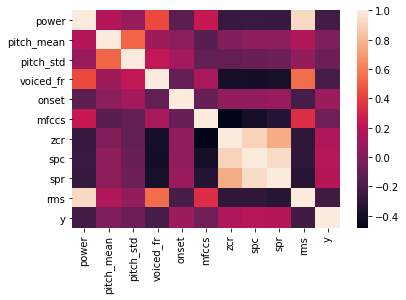

In [ ]:
corrMatrix = df_all.corr()
sns.heatmap(corrMatrix)

As evident from the correlation plot, the Label 'y' is weakly influenced by RMS,Voiced_fr and power. 

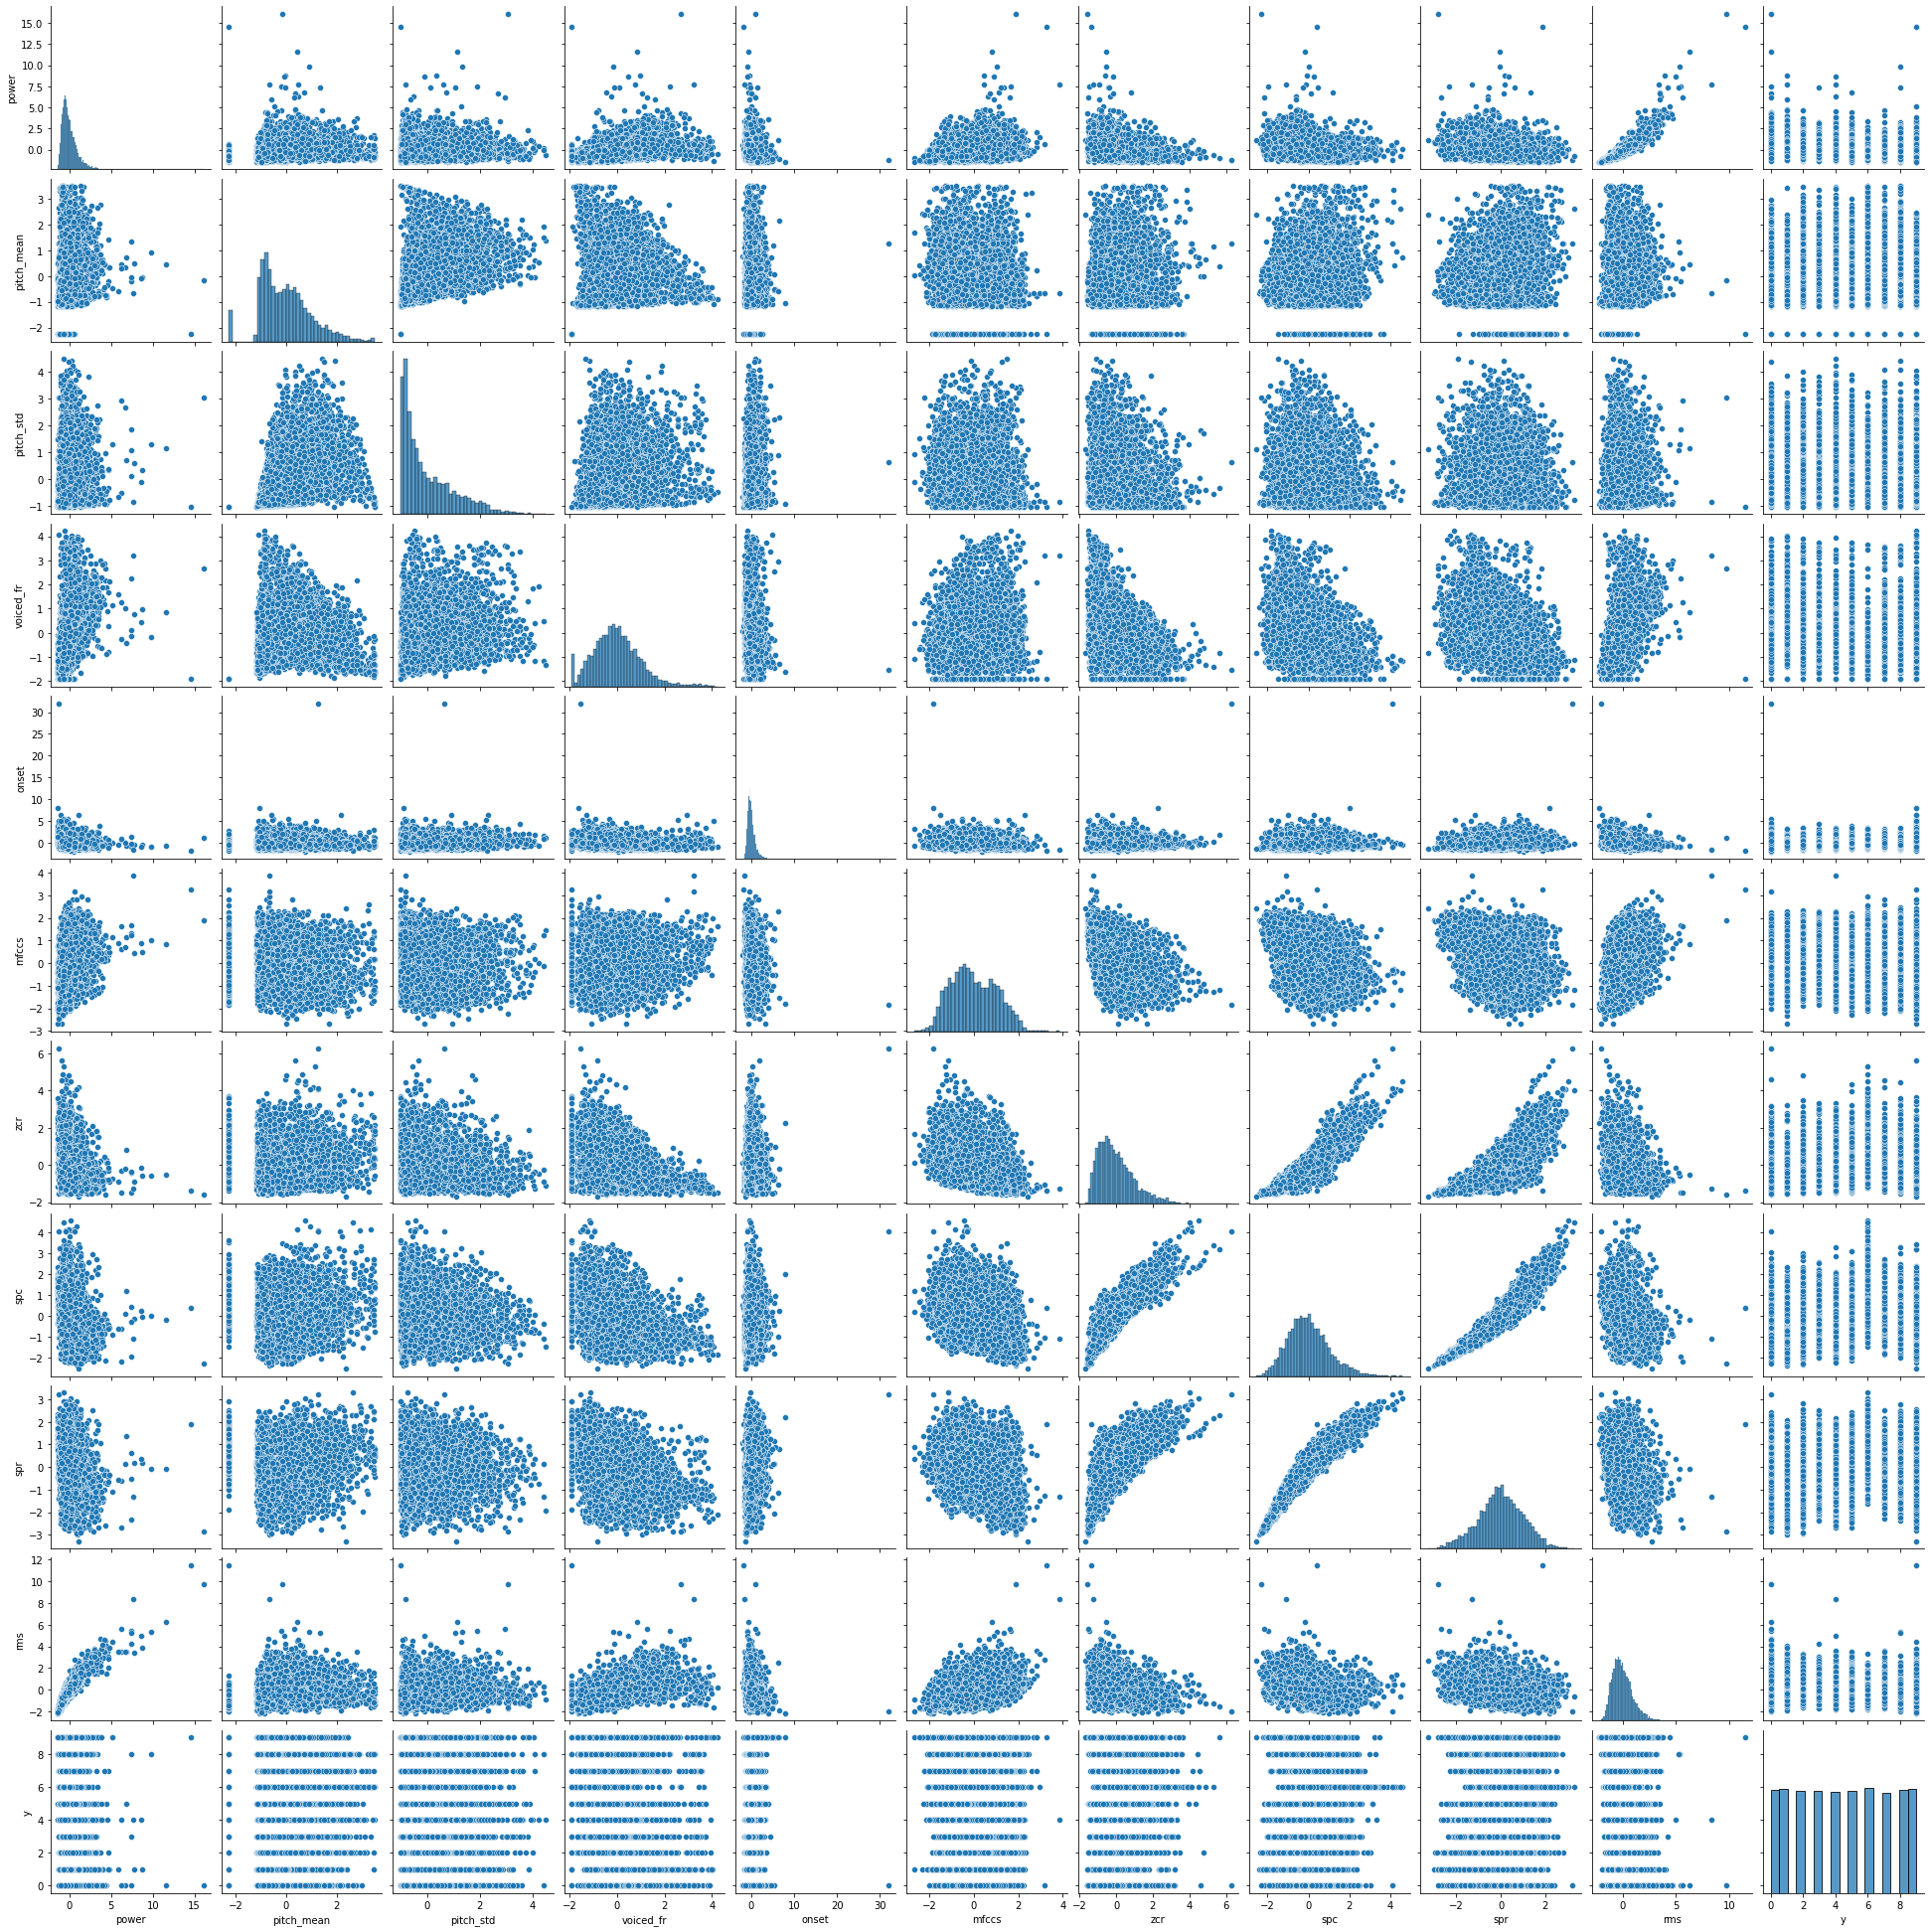

In [ ]:
sns.pairplot(df_all)

These pair plots give us a relation of different attributes to the labels. For example, from the bottom row of plots we can see in power vs label plot that '4' has a higher power or in the mfccs vs label plot the digit '9' has a larger spread compared '3'.

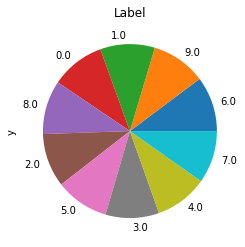

In [ ]:
df_all['y'].value_counts().plot(kind='pie')
plt.title('Label')
plt.grid()
plt.show()

The pie chart again shows that we have a uniformly distributed dataset

#Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.3)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((4573, 10), (1960, 10), (4573,), (1960,))

#THE DEEP LEARNING MODEL

I have used keras to develop a deep connected Multilayer Perceptron. It has 6 densely connected layers and 3 dropout layers. The activation function used is Leaky Rectified Linear Unit. 

The hyper parameters batch size and epoch was updated based on repeated training.
Batch size 16,32,64,128 were used ,with epochs 250,100,70,50 were used

Best results were obtained with batch size = 16 and epochs =250

But in this configuration the model overfit and had a training accuracy of 1.00 and validation accuracy of 0.24

In order to overcome this dropout layers and weight constraints were used, the final training accuracy was 0.3955 and validation accuracy of 0.3684.

In [ ]:
from keras.layers import Activation, Dense, Dropout
from keras.constraints import max_norm
model = Sequential()

model.add(Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.2), input_shape= (X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.2),kernel_constraint=max_norm(3), bias_constraint=max_norm(3)))
model.add(Dropout(0.5))
model.add(Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.2),kernel_constraint=max_norm(3), bias_constraint=max_norm(3)))
model.add(Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.2),kernel_constraint=max_norm(3), bias_constraint=max_norm(3)))
model.add(Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.2),kernel_constraint=max_norm(3), bias_constraint=max_norm(3)))
model.add(Dropout(0.5))
model.add(Dense(32, activation='softmax'))
model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_114 (Dense)            (None, 256)               2816      
_________________________________________________________________
dropout_51 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_115 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_52 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_116 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_117 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_118 (Dense)            (None, 64)              

The model built above has droput layers and weight constraints in the dense layers as witout them the model (batch size=16 and epoch=200) overfit in the data as training accuracy was 1.00 and validation accuracy was 0.05-0.04

In [ ]:
e = 250
history = model.fit(   X_train,
    y_train,
    batch_size=16,
    epochs=e,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_val, y_val),)

Epoch 1/250
286/286 [==============================] - 2s 4ms/step - loss: 2.7715 - accuracy: 0.1273 - val_loss: 2.0585 - val_accuracy: 0.2714
Epoch 2/250
286/286 [==============================] - 1s 3ms/step - loss: 2.1526 - accuracy: 0.2427 - val_loss: 1.9796 - val_accuracy: 0.3122
Epoch 3/250
286/286 [==============================] - 1s 3ms/step - loss: 2.0890 - accuracy: 0.2548 - val_loss: 1.9622 - val_accuracy: 0.3010
Epoch 4/250
286/286 [==============================] - 1s 3ms/step - loss: 2.0015 - accuracy: 0.2900 - val_loss: 1.9313 - val_accuracy: 0.3214
Epoch 5/250
286/286 [==============================] - 1s 3ms/step - loss: 1.9748 - accuracy: 0.2990 - val_loss: 1.9099 - val_accuracy: 0.3163
Epoch 6/250
286/286 [==============================] - 1s 3ms/step - loss: 1.9563 - accuracy: 0.3028 - val_loss: 1.8920 - val_accuracy: 0.3255
Epoch 7/250
286/286 [==============================] - 1s 3ms/step - loss: 1.9497 - accuracy: 0.3096 - val_loss: 1.9000 - val_accuracy: 0.3306

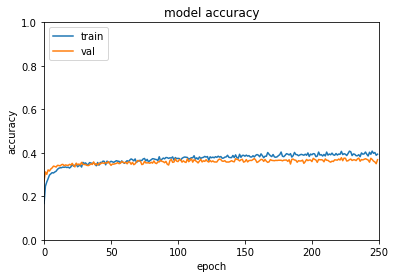

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.axis([0,e,0,1])
plt.show()

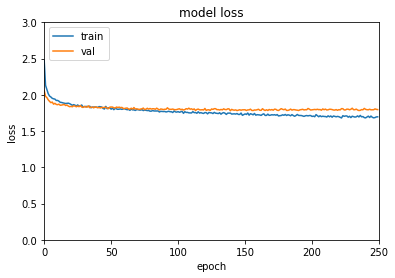

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.axis([0,e,0,3])
plt.show()

Result of expermentation:

PCA with 2 components:
1. Accuracy: 0.1855  
2. Validation Accuracy :0.1923

PCA with 4 components:
1. Accuracy: 0.2648
2. Validation Accuracy : 0.2393

Non-PCA:
With batch size 16 and 250 epochs
1. Accuracy: 0.3955
2. Validation Accuracy : 0.3684

In [ ]:
model.evaluate(X_val, y_val)

62/62 [==============================] - 0s 1ms/step - loss: 1.8333 - accuracy: 0.3592


[1.8332765102386475, 0.359183669090271]

#Summary

My contribution was to use different pemutations and combinations of features, preprocessing, hyperparameters, models and visual analysis to ultimately arrive upon a model with respectable accuracy.

The best accuracy was achieved without the use of PCA 2 and 4 but with the use of all standard scaled features. The model accuracy was 0.3684 which is low but much better then the accuracy of 0.03-0.05 of all digits. Even so the model accuracy is very low to be of significant use in the real world.